In [1]:
using JLD2 # for saving and loading data
using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
using QuasiMonteCarlo # for LHS
using Optimization, OptimizationOptimJL, LineSearches # for optimization
using Trapz	 
using DataFrames, CSV # for data handling
using StatsBase


# include
include("./EDES/including.jl")

# set random seed
Random.seed!(1234);



# Load the synthetic meal response data

In [2]:
data = load("../Results/SyntheticPatientsOutputs.jld2")

# extract meal response data
glc = data["glucose"];
ins = data["insulin"];

time_G = data["time_G"];
time_I = data["time_I"];

IDs = data["ID"];
Health = data["Health"];

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0
glc

7×7×10 Array{Float64, 3}:
[:, :, 1] =
 4.8966   5.89523  7.14197   7.17766  5.31314  4.39216  4.12537
 5.08441  6.09044  7.30393   7.07218  5.34189  4.62604  4.44272
 5.58085  6.63017  7.90338   7.55876  5.77721  5.14538  4.98537
 5.70148  6.72908  8.05849   7.96126  5.8909   5.22628  5.04866
 5.77182  6.79282  8.17425   8.32227  5.99789  5.22574  5.03112
 6.51531  7.62934  9.29465  10.2143   7.22924  5.59541  5.24322
 6.26652  7.32114  8.97583  10.3291   7.56431  5.2466   4.60828

[:, :, 2] =
 4.91528  5.90089  7.09778  6.95272  5.24053  4.46695  4.25186
 5.28351  6.34295  7.6295   7.47358  5.63312  4.80158  4.57038
 5.38861  6.46913  7.78128  7.62225  5.74518  4.8971   4.6613
 5.34661  6.4187   7.72062  7.56284  5.7004   4.85893  4.62496
 4.91823  5.90443  7.10204  6.95689  5.24367  4.46963  4.25441
 4.90218  5.88516  7.07886  6.93419  5.22656  4.45504  4.24052
 5.1728   6.21004  7.46964  7.31698  5.51509  4.70098  4.47462

[:, :, 3] =
 5.06803  6.11981  7.42939   7.37593  5.4261   4

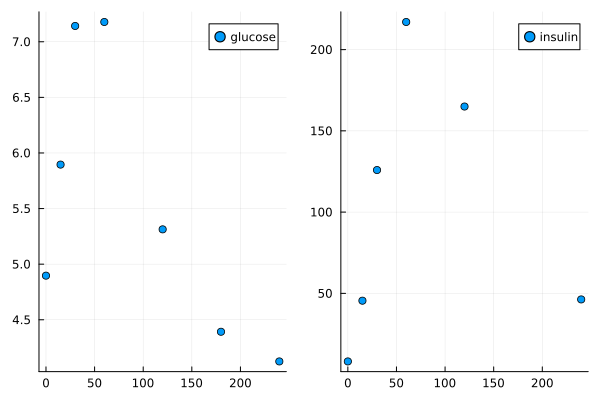

In [3]:
person = 1
meal_test = 1
scatter([time_G, time_I], [glc[meal_test,:,person], ins[meal_test,:,person]], layout = (1,2), label=["glucose" "insulin"],)

In [4]:
include("./EDES/including.jl")
columnnames = ["ID","Meal Test","Health status","k1","k5","k6", "k8"]

# extract the number of meal tests for each patient
counts = countmap(IDs)
n_meal_tests = maximum(values(counts))

parameter_df = DataFrame([name => [] for name in columnnames])
patients = [[glc[j,:,i], ins[j,:,i], BW, G_dose, time_G, time_I] for i in axes(IDs,1) for j in 1:n_meal_tests]
best_parameters_list = []
for i in 1#:size(IDs, 1)
    best_parameters = ParameterEstimation(patients[i]...)
    push!(best_parameters_list, best_parameters)
end

# plot output of the model with the best parameters
best_parameters = best_parameters_list[1]
println(best_parameters)




Optimization successful for this initial set, continuing...
Parameter estimation done!
[0.01040722863429779, 0.01734630475418102, 4.409503730754956, 7.353950257507306]


# Fit the EDES model


In [4]:
using Distributed

n_cores = length(Sys.cpu_info())

# note that this is the same as of the synthetic patients, needs to change if we start changing the weight or the dose
BW = 70 
G_dose::Real = 75000.0


if nprocs()-1 < n_cores
    addprocs(n_cores-nprocs()+1, exeflags="--project")
end

@everywhere begin
    using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
    using Optimization, OptimizationOptimJL, LineSearches # for optimization
    using QuasiMonteCarlo # for LHS
    using Trapz
    include("./EDES/including.jl")
end

columnnames = ["ID","Meal Test","Health status","k1","k5","k6", "k8"]
# estimated_parameters = ["k1","k5","k6", "k8"]

# extract the number of meal tests for each patient
counts = countmap(IDs)
n_meal_tests = maximum(values(counts))

patients = [[glc[j,:,i], ins[j,:,i], BW, G_dose, time_G, time_I] for i in axes(IDs,1) for j in 1:n_meal_tests]
results = pmap(x -> ParameterEstimation(x...), patients)

# close the parallel pool
rmprocs(procs()[2:end])

# initialise the dataframe
df_fits = DataFrame()
for col in columnnames
    df_fits[!, Symbol(col)] = Float64[]
end

# Flatten the IDs matrix into a vector
IDs_vec = vec(IDs')
# Repeat the Health vector n times to match the length of IDs_vec
Health_vec = repeat(Health, inner = n_meal_tests)
# Create a vector for meal test numbers
meal_tests = repeat(1:n_meal_tests, size(IDs)[1])

for i in 1:length(IDs_vec)
    # Add the meal test number, health status, and ID to the start of the result vector
    prepend!(results[i], [IDs_vec[i], meal_tests[i], Health_vec[i]])
end

# Fill the dataframe with the results
for i in 1:length(results)
    println(results[i])
    push!(df_fits, transpose(results[i]))
end

      From worker 9:	Optimization successful for this initial set, continuing...
      From worker 9:	Parameter estimation done!
      From worker 8:	Optimization successful for this initial set, continuing...
      From worker 8:	Parameter estimation done!
      From worker 6:	Optimization successful for this initial set, continuing...
      From worker 6:	Parameter estimation done!
      From worker 7:	Optimization successful for this initial set, continuing...
      From worker 7:	Parameter estimation done!
      From worker 2:	Optimization successful for this initial set, continuing...
      From worker 2:	Parameter estimation done!
      From worker 3:	Optimization successful for this initial set, continuing...
      From worker 3:	Parameter estimation done!
      From worker 8:	Optimization successful for this initial set, continuing...
      From worker 8:	Parameter estimation done!
      From worker 4:	Optimization successful for this initial set, continuing...
      From worke

In [5]:
df_fits

Row,ID,Meal Test,Health status,k1,k5,k6,k8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.0,0.0,0.0104072,0.0173463,4.40951,7.354
2,1.0,2.0,0.0,0.0104362,0.0155601,5.10032,7.57521
3,1.0,3.0,0.0,0.0105299,0.0131662,5.54484,7.59195
4,1.0,4.0,0.0,0.0104272,0.0116063,5.3463,7.08974
5,1.0,5.0,0.0,0.0103704,0.0109003,4.90771,6.83445
6,1.0,6.0,0.0,0.0104962,0.00845506,3.49573,7.08165
7,1.0,7.0,0.0,0.0104589,0.0058106,3.53309,7.01873
8,2.0,1.0,1.0,0.01038,0.0164254,5.00868,7.44119
9,2.0,2.0,1.0,0.0105607,0.0166048,4.63033,7.29184


In [8]:
CSV.write("./Results/Synthetic_population_fits.csv", df_fits)

"./Results/Synthetic_population_fits.csv"